# Single base substitution signature correlation with mutations per gene.
All the non-synonymous mutations belong to a certain gene. The question we address here is, are the `SBS4` and `SBS87` signatures related to mutations in specific genes?

In [1]:
from typing import Optional

from matplotlib import pyplot as plt
from numpy import array
import pandas as pd
from pandas import DataFrame, Series, concat, read_csv
from scipy.stats import fisher_exact, kendalltau
from sklearn.metrics import roc_auc_score
from statsmodels.stats.multitest import fdrcorrection
from statkit.naive_bayes import NaiveBayesClassifier
from statkit.non_parametric import bootstrap_score
from statkit.views import format_p_value

from utils import polish_variable_names

In [2]:
# Add end-to-end package to path.
import sys
from pathlib import Path

sys.path.append(str(Path('../').absolute()))

In [3]:
from src.const import TCGA_GENES_LUNG_CANCER
from src.plot import plot_image


RESOURCE_DIR = Path('../src/resources')


tso500_genes = pd.read_csv(RESOURCE_DIR / 'tso500_genes.csv').squeeze().tolist()
topdecile = pd.read_csv('../artifacts/expressed_genes_decile.csv', index_col=0)
topdecile_genes = topdecile.index.tolist()

In [4]:
# List of coding tumor suppressor genes according to 
# Tumor Suppressor Gene Database website version 2.0. Extracted 01-09-2022.
tumor_suppressor_genes = pd.read_csv(
    RESOURCE_DIR / 'tumor-suppressor-genes-coding.csv', 
    index_col=0, 
    names=['Entrez Gene ID', 'Gene Name', 'Description']
)['Gene Name']

In [5]:
# List of oncogenes according to Cancer Gene Census, COSMIC v96.
onco_genes = pd.read_csv(
    RESOURCE_DIR / 'cancer_gene_census_cosmicv96.tsv', 
    sep='\t'
)['Gene Symbol'].tolist()

In [6]:
# Human DNA repair genes according to the website:
# https://www.mdanderson.org/documents/Labs/Wood-Laboratory/human-dna-repair-genes.html
# Extracted 01-09-2022.
dna_repair_genes = pd.read_csv(
    '../artifacts/human-dna-repair-genes.csv', 
)['Gene']

In [7]:
n_genes_decile = len(topdecile)
n_top0_05_genes = n_genes_decile // 2
n_top0_025_genes = n_genes_decile // 4

top0_05_genes = topdecile.squeeze().sort_values()[-n_top0_05_genes:].index
top0_025_genes = topdecile.squeeze().sort_values()[-n_top0_025_genes:].index

In [8]:
hrtw_signatures = read_csv('../artifacts/hartwig_wes_signature.tsv', sep='\t', index_col=0)
hrtw_tmb = read_csv('../artifacts/hartwig_tmb.tsv', sep='\t', index_col=0)
X_hrtw = polish_variable_names(hrtw_signatures)

# Add TMB column.
hrtw_tcga = read_csv('../artifacts/hartwig_tmb_tcga.tsv', sep='\t', index_col=0)
hrtw_tso500 = read_csv('../artifacts/hartwig_tmb_tso500.tsv', sep='\t', index_col=0)
hrtw_topdecile = read_csv('../artifacts/hartwig_tmb_topdecile.tsv', sep='\t', index_col=0)

assert all(X_hrtw.index == hrtw_tcga.index)
assert all(X_hrtw.index == hrtw_tso500.index)
assert all(X_hrtw.index == hrtw_topdecile.index)

In [9]:
def get_significant_columns(
    data: DataFrame, 
    columns: list, 
    reference_values: Series,
    to_disk: Optional[str] = None,
) -> DataFrame:
    """Test `columns` for significant correlation with `reference_values`.
    
    Args:
        columns: List of columns to test for.
        reference_values: Correlate each column with this value.
        to_disk: Optional path to store the correlations and p-values to disk.
    """
    result = DataFrame(columns=['statistic', 'pvalue'], index=columns)
    for c in columns:
        if data[c].var() == 0.0:
            print(f'Skipping zero variance {c}.')
            continue
        rho, p_value = kendalltau(data[c], reference_values)
        result.loc[c] = [rho, p_value]
        
    result.dropna(axis=0, inplace=True)
    _, pvalue_corrected = fdrcorrection(result.pvalue)
    result['pvalue-corrected'] = pvalue_corrected
    
    if to_disk is not None:
        result.to_csv(to_disk)
    
    return result

First, we test the 23 genes that were significantly mutated in TCGA.

Are there any tumor suppressor genes in TCGA?

In [10]:
pd.Series(TCGA_GENES_LUNG_CANCER).isin(tumor_suppressor_genes).sum()

10

How many are oncogenes?

In [11]:
pd.Series(TCGA_GENES_LUNG_CANCER).isin(onco_genes).sum()

20

Are there genes significantly correlated with SBS4 signature?

In [12]:
sbs4_corr = get_significant_columns(
    data=hrtw_tcga, 
    reference_values=X_hrtw['SBS4'], 
    columns=TCGA_GENES_LUNG_CANCER,
    to_disk='supporting_material/tcga-sbs4.csv'
)
sbs4_corr[sbs4_corr['pvalue-corrected'] <= 0.05]

Skipping zero variance MET.
Skipping zero variance MLL2.


Empty DataFrame
Columns: [statistic, pvalue, pvalue-corrected]
Index: []

In [13]:
sbs87_corr = get_significant_columns(
    data=hrtw_tcga, 
    reference_values=X_hrtw['SBS87'], 
    columns=TCGA_GENES_LUNG_CANCER,
    to_disk='supporting_material/tcga-sbs87.csv',
)
sbs87_corr[sbs87_corr['pvalue-corrected'] <= 0.05]

Skipping zero variance MET.
Skipping zero variance MLL2.


Empty DataFrame
Columns: [statistic, pvalue, pvalue-corrected]
Index: []

Apparantly, no significant hits were found. We now expand our search to the clinically revelant TSO500 selection, with the accompanying larger multiple testing burden.

In [14]:
sbs4_corr = get_significant_columns(
    data=hrtw_tso500, 
    reference_values=X_hrtw['SBS4'],
    columns=tso500_genes,
    to_disk='supporting_material/tso500-sbs4.csv',
)
sbs87_corr = get_significant_columns(
    data=hrtw_tso500, 
    reference_values=X_hrtw['SBS87'], 
    columns=tso500_genes,
    to_disk='supporting_material/tso500-sbs87.csv',
)

Skipping zero variance BRD4.
Skipping zero variance FAM175A.
Skipping zero variance GEN1.
Skipping zero variance MAP3K14.
Skipping zero variance NPM1.
Skipping zero variance ACVR1.
Skipping zero variance BTG1.
Skipping zero variance GID4.
Skipping zero variance NRAS.
Skipping zero variance TCEB1.
Skipping zero variance FANCC.
Skipping zero variance IKBKE.
Skipping zero variance AKT1.
Skipping zero variance MAPK3.
Skipping zero variance SDHA.
Skipping zero variance TCF7L2.
Skipping zero variance SDHAF2.
Skipping zero variance TERC.
Skipping zero variance FANCF.
Skipping zero variance GNAQ.
Skipping zero variance MCL1.
Skipping zero variance PRDM1.
Skipping zero variance pTERT.
Skipping zero variance FANCG.
Skipping zero variance INHA.
Skipping zero variance ALOX12B.
Skipping zero variance FANCI.
Skipping zero variance SDHD.
Skipping zero variance GPS2.
Skipping zero variance CCND1.
Skipping zero variance PRSS8.
Skipping zero variance CCND3.
Skipping zero variance IRF2.
Skipping zero var

In [15]:
sbs87_significant = sbs87_corr[sbs87_corr['pvalue-corrected'] <= 0.05]
sbs4_significant = sbs4_corr[sbs4_corr['pvalue-corrected'] <= 0.05]

Despite the larger multiple testing penalty, we have found several genes signifcantly correlated with smoking signature `SBS4`.

In [16]:
sbs4_significant

statistic    pvalue pvalue-corrected
RUNX1T1  0.306008  0.000289         0.023427
NRG1     0.284128  0.000711         0.035988
PTPRD    0.454544       0.0         0.000017
PTPRT     0.42451       0.0         0.000067
ATM       0.29702  0.000434         0.029316
EPHA5    0.321091  0.000133         0.013455
MTOR       0.2899  0.000595         0.034415
LRP1B      0.3686  0.000004         0.000529

In [17]:
print("--------- SBS4 ---------")
for gene, row in sbs4_significant.sort_index().iterrows():
    q_value = row["pvalue-corrected"]
    print(
        gene,
        "({})".format(
            format_p_value(q_value, latex=True, symbol="q", format="compact")
        ),
        "(q={:.3f})".format(q_value),
    )


--------- SBS4 ---------
ATM ($q = 0.029$) (q=0.029)
EPHA5 ($q = 0.013$) (q=0.013)
LRP1B ($q = 5.3 \cdot 10^{-4}$) (q=0.001)
MTOR ($q = 0.034$) (q=0.034)
NRG1 ($q = 0.036$) (q=0.036)
PTPRD ($q = 1.7 \cdot 10^{-5}$) (q=0.000)
PTPRT ($q = 6.7 \cdot 10^{-5}$) (q=0.000)
RUNX1T1 ($q = 0.023$) (q=0.023)


In [18]:
def enrichment_analysis(target: set, annotations: set, reference: set) -> tuple[float, float, list]:
    """Determine if `target` is enriched/depleted in `annotated` relative to `reference` set.
    
    Returns:
        Ratio of annotated targets, ratio of annotated reference, and contigency table.
    """
    n_reference = len(reference)
    n_target = len(target)
    n_target_ann = len(target.intersection(annotations))
    n_target_not_ann = n_target - n_target_ann
    n_ref_ann = len(reference.intersection(annotations))
    
    table = [
        [n_target_ann, n_target_not_ann ],
        [n_ref_ann - n_target_ann, n_reference - n_ref_ann - n_target_not_ann]
    ]
    
    target_ratio = n_target_ann / n_target
    reference_ratio = n_ref_ann / n_reference
    return target_ratio, reference_ratio, table

What are the tumor supressor genes?

In [19]:
print('Tumor suppressor genes')
for g in sorted(set(sbs4_significant.index).intersection(tumor_suppressor_genes)):
    print(f'    - {g}')

Tumor suppressor genes
    - ATM
    - LRP1B
    - PTPRD
    - PTPRT


What are the genes that are involved in DNA repair?

In [20]:
print('DNA repair genes')
for g in sorted(set(sbs4_significant.index).intersection(onco_genes)):
    print(f'    - {g}')

DNA repair genes
    - ATM
    - LRP1B
    - MTOR
    - NRG1
    - PTPRD
    - PTPRT
    - RUNX1T1


In [21]:
print('Oncogenes')
for g in sorted(set(sbs4_significant.index).intersection(dna_repair_genes)):
    print(f'    - {g}')

Oncogenes
    - ATM


Is this list of genes enriched in tumor suppressor genes, compared to all TSO500 genes?

In [22]:
ratio_tsg_sbs4, ratio_tsg_tso500, table_tsg_sbs4 = enrichment_analysis(
    target=set(sbs4_significant.index),
    annotations=set(tumor_suppressor_genes),
    reference=set(tso500_genes),
)

odds_ratio, p_value = fisher_exact(table_tsg_sbs4)
enrichment = ratio_tsg_sbs4 / ratio_tsg_tso500
print(f'Tumor suppressor enrichment SBS4 genes {enrichment:.2f} fold (p={p_value:.2f}, Fisher exact test)', )

Tumor suppressor enrichment SBS4 genes 1.67 fold (p=0.25, Fisher exact test)


Is the list of genes enriched in DNA repair genes, compared to all TSO500 genes?

In [23]:
ratio_repair_sbs4, ratio_repair_tso500, table_repair_sbs4 = enrichment_analysis(
    target=set(sbs4_significant.index),
    annotations=set(dna_repair_genes),
    reference=set(tso500_genes),
)

odds_ratio, p_value = fisher_exact(table_repair_sbs4)
enrichment = ratio_repair_sbs4 / ratio_repair_tso500
print(f'DNA repair enrichment SBS4 genes {enrichment:.2f} fold (p={p_value:.2f}, Fisher exact test)', )

DNA repair enrichment SBS4 genes 1.33 fold (p=0.55, Fisher exact test)


Is the list of genes enriched in oncogenes, compared to all TSO500 genes?

In [24]:
ratio_onco_sbs4, ratio_onco_tso500, table_onco_sbs4 = enrichment_analysis(
    target=set(sbs4_significant.index),
    annotations=set(onco_genes),
    reference=set(tso500_genes),
)

odds_ratio, p_value = fisher_exact(table_onco_sbs4)
enrichment = ratio_onco_sbs4 / ratio_onco_tso500
print(f'Oncogene enrichment SBS4 genes {enrichment:.2f} fold (p={p_value:.2f}, Fisher exact test)', )

Oncogene enrichment SBS4 genes 1.43 fold (p=0.16, Fisher exact test)


Four of these, are also significantly correlated with `SBS87`.

In [25]:
sbs87_significant

statistic    pvalue pvalue-corrected
RUNX1T1  0.294955  0.000381         0.038564
PTPRD    0.315734  0.000108         0.021473
PTPRT    0.346583  0.000023         0.009146
LRP1B    0.296576  0.000159         0.021473

In [26]:
print("--------- SBS87 ---------")
for gene, row in sbs87_significant.sort_index().iterrows():
    q_value = row["pvalue-corrected"]
    print(
        gene,
        "({})".format(
            format_p_value(
                row["pvalue-corrected"], latex=True, symbol="q", format="compact"
            )
        ),
        "(q={:.3f})".format(q_value),
    )


--------- SBS87 ---------
LRP1B ($q = 0.021$) (q=0.021)
PTPRD ($q = 0.021$) (q=0.021)
PTPRT ($q = 0.0091$) (q=0.009)
RUNX1T1 ($q = 0.039$) (q=0.039)


In [27]:
ratio_tsg_sbs87, ratio_tsg_tso500, table_tsg_sbs87 = enrichment_analysis(
    target=set(sbs87_significant.index),
    annotations=set(tumor_suppressor_genes),
    reference=set(tso500_genes),
)

odds_ratio, p_value = fisher_exact(table_tsg_sbs87)
enrichment = ratio_tsg_sbs87 / ratio_tsg_tso500
print(f'Tumor suppressor enrichment SBS87 genes {enrichment:.2f} fold (p={p_value:.2f}, Fisher exact test)', )

Tumor suppressor enrichment SBS87 genes 2.50 fold (p=0.08, Fisher exact test)


In [28]:
ratio_repair_sbs87, ratio_repair_tso500, table_repair_sbs87 = enrichment_analysis(
    target=set(sbs87_significant.index),
    annotations=set(dna_repair_genes),
    reference=set(tso500_genes),
)

odds_ratio, p_value = fisher_exact(table_repair_sbs87)
enrichment = ratio_repair_sbs87 / ratio_repair_tso500
print(f'DNA repair enrichment SBS87 genes {enrichment:.2f} fold (p={p_value:.2f}, Fisher exact test)', )

DNA repair enrichment SBS87 genes 0.00 fold (p=1.00, Fisher exact test)


In [29]:
ratio_onco_sbs87, ratio_onco_tso500, table_onco_sbs87 = enrichment_analysis(
    target=set(sbs4_significant.index),
    annotations=set(onco_genes),
    reference=set(tso500_genes),
)

odds_ratio, p_value = fisher_exact(table_onco_sbs87)
enrichment = ratio_onco_sbs87 / ratio_onco_tso500
print(f'Oncogene enrichment SBS87 genes {enrichment:.2f} fold (p={p_value:.2f}, Fisher exact test)', )

Oncogene enrichment SBS87 genes 1.43 fold (p=0.16, Fisher exact test)


## Correlation plot
We now generate a plot that depicts the correlations mutations in genes and the single base substitution signatures.

In [30]:
# For the plot below, we assume that all significant genes in SBS87 are contained in the SBS4 set.
genes = set(sbs4_significant.index).union(sbs87_significant.index)
assert set(genes) == set(sbs4_significant.index)

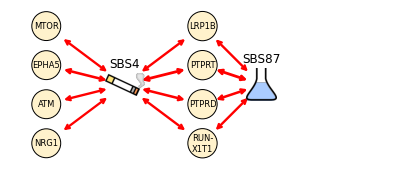

In [31]:
plt.figure(figsize=(7, 4))
items = sbs87_significant["statistic"]
n_items = len(items)

ax = plt.gca()
ax.axis("off")
plt.ylim([-n_items, n_items])
plt.xlim([-10, 10])

# Place thiopurine symbol here.
x_sbs87 = array([3, 0])
x_sbs4 = array([-4, 0])

for i, (name, value) in enumerate(items.items()):
    if len(name) > 6:
        name = name[:3] + "-\n" + name[3:]
    value_label = r"+{:.1f} %".format(value * 100)

    x_i = array([0, -(n_items - 1) + 2 * i])
    c_i = plt.Circle(x_i, radius=0.75, edgecolor="k", facecolor="#fff2ccff")
    ax.text(
        x_i[0],
        x_i[1],
        name,
        horizontalalignment="center",
        verticalalignment="center",
        fontsize="small",
    )

    x_arrow = x_sbs87 - x_i
    shrink_arrow = 0.6
    ax.annotate(
        "",
        xy=x_i + x_arrow * (1 - shrink_arrow) / 2,
        xytext=x_i + (1 + shrink_arrow) / 2 * x_arrow,
        xycoords="data",
        textcoords="data",
        arrowprops=dict(
            arrowstyle="<->", connectionstyle="arc3", color="r", lw=2 * 4 * value
        ),
    )

    x_arrow = x_sbs4 - x_i

    ax.annotate(
        "",
        xy=x_i + x_arrow * (1 - shrink_arrow) / 2,
        xytext=x_i + (1 + shrink_arrow) / 2 * x_arrow,
        xycoords="data",
        textcoords="data",
        arrowprops=dict(
            arrowstyle="<->", connectionstyle="arc3", color="r", lw=2 * 4 * value
        ),
    )

    ax.add_patch(c_i)


items = sbs4_significant[~sbs4_significant.index.isin(sbs87_significant.index)][
    "statistic"
]
n_items = len(items)
for i, (name, value) in enumerate(items.items()):
    value_label = r"+{:.1f} %".format(value * 100)

    x_i = array([-8, -(n_items - 1) + 2 * i])
    c_i = plt.Circle(x_i, radius=0.74, edgecolor="k", facecolor="#fff2ccff")
    ax.text(
        x_i[0],
        x_i[1],
        name,
        horizontalalignment="center",
        verticalalignment="center",
        fontsize="small",
    )

    x_arrow = x_sbs4 - x_i

    ax.annotate(
        "",
        xy=x_i + x_arrow * (1 - shrink_arrow) / 2,
        xytext=x_i + (1 + shrink_arrow) / 2 * x_arrow,
        xycoords="data",
        textcoords="data",
        arrowprops=dict(
            arrowstyle="<->", connectionstyle="arc3", color="r", lw=2 * 4 * value
        ),
    )

    ax.add_patch(c_i)

ax_87 = plot_image(
    "../figures/icons/thiopurine.png",
    x=x_sbs87[0],
    y=x_sbs87[1],
    height=1.5,
    width="auto",
    ax=ax,
)
ax_4 = plot_image(
    "../figures/icons/cigarette.png",
    x=x_sbs4[0],
    y=x_sbs4[1],
    width=2.0,
    height="auto",
    ax=ax,
)
ax_4.set_title("SBS4")
ax_87.set_title("SBS87")
ax.set_aspect("equal")
plt.savefig("figs/signature-correlations.eps", bbox_inches="tight")
plt.savefig("figs/signature-correlations.png", bbox_inches="tight")
plt.savefig("figs/signature-correlations.pdf", bbox_inches="tight")
plt.savefig("figs/signature-correlations.svg", bbox_inches="tight")


## Highly expressed gene selection
### Top 10 %

In [32]:
sbs4_corr = get_significant_columns(
    data=hrtw_topdecile, 
    reference_values=X_hrtw['SBS4'], 
    columns=topdecile_genes,
    to_disk='supporting_material/expression-top0_10-sbs4.csv',
)

sbs4_significant = sbs4_corr[sbs4_corr['pvalue-corrected'] <= 0.05]
sbs4_significant

Skipping zero variance RAB25.
Skipping zero variance CKS1B.
Skipping zero variance VAPA.
Skipping zero variance MAPK3.
Skipping zero variance EIF2B1.
Skipping zero variance SUMO3.
Skipping zero variance RBM47.
Skipping zero variance SF3B6.
Skipping zero variance FAM210B.
Skipping zero variance TLNRD1.
Skipping zero variance DAPK3.
Skipping zero variance ZNF189.
Skipping zero variance UBALD1.
Skipping zero variance KIF22.
Skipping zero variance COX20.
Skipping zero variance PDZD11.
Skipping zero variance SUMO2.
Skipping zero variance NDUFB7.
Skipping zero variance JMJD4.
Skipping zero variance RETREG3.
Skipping zero variance LAMTOR4.
Skipping zero variance NIT1.
Skipping zero variance UGDH.
Skipping zero variance RASSF1.
Skipping zero variance TRABD.
Skipping zero variance MFGE8.
Skipping zero variance ITPRID2.
Skipping zero variance SSU72.
Skipping zero variance COMTD1.
Skipping zero variance GPR108.
Skipping zero variance ARL8A.
Skipping zero variance PPP4R3A.
Skipping zero variance S

Skipping zero variance INTS11.
Skipping zero variance NIBAN2.
Skipping zero variance COX7B.
Skipping zero variance MACROH2A1.
Skipping zero variance S100A14.
Skipping zero variance UQCRB.
Skipping zero variance MID1IP1.
Skipping zero variance FAM136A.
Skipping zero variance PNP.
Skipping zero variance CSTF2T.
Skipping zero variance CDIPT.
Skipping zero variance WARS1.
Skipping zero variance NDUFS5.
Skipping zero variance EIF1AD.
Skipping zero variance TOMM20.
Skipping zero variance BCL3.
Skipping zero variance SELENOS.
Skipping zero variance ANKRD13D.
Skipping zero variance ISCU.
Skipping zero variance POLR2K.
Skipping zero variance NKTR.
Skipping zero variance ANXA11.
Skipping zero variance ESRP2.
Skipping zero variance RPS19BP1.
Skipping zero variance SAR1A.
Skipping zero variance APOL6.
Skipping zero variance DMAP1.
Skipping zero variance SMIM30.
Skipping zero variance TMEM208.
Skipping zero variance CCT7.
Skipping zero variance AKT1.
Skipping zero variance TCTA.
Skipping zero varia

Empty DataFrame
Columns: [statistic, pvalue, pvalue-corrected]
Index: []

In [33]:
sbs87_corr = get_significant_columns(
    data=hrtw_topdecile, 
    reference_values=X_hrtw['SBS87'], 
    columns=topdecile_genes,
    to_disk='supporting_material/expression-top0_10-sbs87.csv',
)

sbs87_significant = sbs87_corr[sbs87_corr['pvalue-corrected'] <= 0.05]
sbs87_significant

Skipping zero variance RAB25.
Skipping zero variance CKS1B.
Skipping zero variance VAPA.
Skipping zero variance MAPK3.
Skipping zero variance EIF2B1.
Skipping zero variance SUMO3.
Skipping zero variance RBM47.
Skipping zero variance SF3B6.
Skipping zero variance FAM210B.
Skipping zero variance TLNRD1.
Skipping zero variance DAPK3.
Skipping zero variance ZNF189.
Skipping zero variance UBALD1.
Skipping zero variance KIF22.
Skipping zero variance COX20.
Skipping zero variance PDZD11.
Skipping zero variance SUMO2.
Skipping zero variance NDUFB7.
Skipping zero variance JMJD4.
Skipping zero variance RETREG3.
Skipping zero variance LAMTOR4.
Skipping zero variance NIT1.
Skipping zero variance UGDH.
Skipping zero variance RASSF1.
Skipping zero variance TRABD.
Skipping zero variance MFGE8.
Skipping zero variance ITPRID2.
Skipping zero variance SSU72.
Skipping zero variance COMTD1.
Skipping zero variance GPR108.
Skipping zero variance ARL8A.
Skipping zero variance PPP4R3A.
Skipping zero variance S

Skipping zero variance BCL3.
Skipping zero variance SELENOS.
Skipping zero variance ANKRD13D.
Skipping zero variance ISCU.
Skipping zero variance POLR2K.
Skipping zero variance NKTR.
Skipping zero variance ANXA11.
Skipping zero variance ESRP2.
Skipping zero variance RPS19BP1.
Skipping zero variance SAR1A.
Skipping zero variance APOL6.
Skipping zero variance DMAP1.
Skipping zero variance SMIM30.
Skipping zero variance TMEM208.
Skipping zero variance CCT7.
Skipping zero variance AKT1.
Skipping zero variance TCTA.
Skipping zero variance EIF2B5.
Skipping zero variance YKT6.
Skipping zero variance WBP2.
Skipping zero variance EMC4.
Skipping zero variance PA2G4.
Skipping zero variance RETREG2.
Skipping zero variance SLC35C2.
Skipping zero variance ACTR1B.
Skipping zero variance IDH3B.
Skipping zero variance PTOV1.
Skipping zero variance SOD1.
Skipping zero variance PPP4C.
Skipping zero variance LGALS3.
Skipping zero variance SETD5.
Skipping zero variance HYI.
Skipping zero variance RPS15A.
S

Skipping zero variance ATXN7L3B.
Skipping zero variance ILF2.
Skipping zero variance GPAA1.
Skipping zero variance RPS26.
Skipping zero variance CCNL1.
Skipping zero variance ILK.
Skipping zero variance PSMB6.
Skipping zero variance SLC25A3.
Skipping zero variance SELENOW.
Skipping zero variance NPM1.
Skipping zero variance UBA1.
Skipping zero variance NAXE.
Skipping zero variance BTG1.
Skipping zero variance TMED2.
Skipping zero variance H2AC4.
Skipping zero variance RPL30.
Skipping zero variance CTSA.
Skipping zero variance H3C1.
Skipping zero variance MRPS16.
Skipping zero variance H2BC10.
Skipping zero variance MAF1.
Skipping zero variance H2BC8.
Skipping zero variance CCN1.
Skipping zero variance STAT2.
Skipping zero variance PGGHG.
Skipping zero variance KDELR1.
Skipping zero variance MAFB.
Skipping zero variance LGALS1.
Skipping zero variance EIF5.
Skipping zero variance KRT7.
Skipping zero variance TRIR.
Skipping zero variance TLE5.
Skipping zero variance SRSF7.
Skipping zero v

Empty DataFrame
Columns: [statistic, pvalue, pvalue-corrected]
Index: []

### Top 5 \%

In [34]:
sbs4_corr = get_significant_columns(
    data=hrtw_topdecile, 
    reference_values=X_hrtw['SBS4'], 
    columns=top0_05_genes,
    to_disk='supporting_material/expression-top0_05-sbs4.csv',
)

sbs4_significant = sbs4_corr[sbs4_corr['pvalue-corrected'] <= 0.05]
sbs4_significant


Skipping zero variance ANKRD13D.
Skipping zero variance ISCU.
Skipping zero variance POLR2K.
Skipping zero variance NKTR.
Skipping zero variance ANXA11.
Skipping zero variance ESRP2.
Skipping zero variance RPS19BP1.
Skipping zero variance SAR1A.
Skipping zero variance APOL6.
Skipping zero variance DMAP1.
Skipping zero variance SMIM30.
Skipping zero variance TMEM208.
Skipping zero variance CCT7.
Skipping zero variance AKT1.
Skipping zero variance TCTA.
Skipping zero variance EIF2B5.
Skipping zero variance YKT6.
Skipping zero variance WBP2.
Skipping zero variance EMC4.
Skipping zero variance PA2G4.
Skipping zero variance RETREG2.
Skipping zero variance SLC35C2.
Skipping zero variance ACTR1B.
Skipping zero variance IDH3B.
Skipping zero variance PTOV1.
Skipping zero variance SOD1.
Skipping zero variance PPP4C.
Skipping zero variance LGALS3.
Skipping zero variance SETD5.
Skipping zero variance HYI.
Skipping zero variance RPS15A.
Skipping zero variance SREBF1.
Skipping zero variance TM4SF1.


Skipping zero variance H2AC4.
Skipping zero variance RPL30.
Skipping zero variance CTSA.
Skipping zero variance H3C1.
Skipping zero variance MRPS16.
Skipping zero variance H2BC10.
Skipping zero variance MAF1.
Skipping zero variance H2BC8.
Skipping zero variance CCN1.
Skipping zero variance STAT2.
Skipping zero variance PGGHG.
Skipping zero variance KDELR1.
Skipping zero variance MAFB.
Skipping zero variance LGALS1.
Skipping zero variance EIF5.
Skipping zero variance KRT7.
Skipping zero variance TRIR.
Skipping zero variance TLE5.
Skipping zero variance SRSF7.
Skipping zero variance HNRNPC.
Skipping zero variance SLC25A39.
Skipping zero variance CALM3.
Skipping zero variance STUB1.
Skipping zero variance TPM2.
Skipping zero variance RPL14.
Skipping zero variance UQCRQ.
Skipping zero variance WSB1.
Skipping zero variance CCND1.
Skipping zero variance COX4I1.
Skipping zero variance C6orf62.
Skipping zero variance CTSZ.
Skipping zero variance RPL34.
Skipping zero variance SEC61A1.
Skipping 

Empty DataFrame
Columns: [statistic, pvalue, pvalue-corrected]
Index: []

In [35]:
sbs87_corr = get_significant_columns(
    data=hrtw_topdecile, 
    reference_values=X_hrtw['SBS87'], 
    columns=top0_05_genes,
    to_disk='supporting_material/expression-top0_05-sbs87.csv',
)

sbs87_significant = sbs87_corr[sbs87_corr['pvalue-corrected'] <= 0.05]
sbs87_significant

Skipping zero variance ANKRD13D.
Skipping zero variance ISCU.
Skipping zero variance POLR2K.
Skipping zero variance NKTR.
Skipping zero variance ANXA11.
Skipping zero variance ESRP2.
Skipping zero variance RPS19BP1.
Skipping zero variance SAR1A.
Skipping zero variance APOL6.
Skipping zero variance DMAP1.
Skipping zero variance SMIM30.
Skipping zero variance TMEM208.
Skipping zero variance CCT7.
Skipping zero variance AKT1.
Skipping zero variance TCTA.
Skipping zero variance EIF2B5.
Skipping zero variance YKT6.
Skipping zero variance WBP2.
Skipping zero variance EMC4.
Skipping zero variance PA2G4.
Skipping zero variance RETREG2.
Skipping zero variance SLC35C2.
Skipping zero variance ACTR1B.
Skipping zero variance IDH3B.
Skipping zero variance PTOV1.
Skipping zero variance SOD1.
Skipping zero variance PPP4C.
Skipping zero variance LGALS3.
Skipping zero variance SETD5.
Skipping zero variance HYI.
Skipping zero variance RPS15A.
Skipping zero variance SREBF1.
Skipping zero variance TM4SF1.


Skipping zero variance SELENOW.
Skipping zero variance NPM1.
Skipping zero variance UBA1.
Skipping zero variance NAXE.
Skipping zero variance BTG1.
Skipping zero variance TMED2.
Skipping zero variance H2AC4.
Skipping zero variance RPL30.
Skipping zero variance CTSA.
Skipping zero variance H3C1.
Skipping zero variance MRPS16.
Skipping zero variance H2BC10.
Skipping zero variance MAF1.
Skipping zero variance H2BC8.
Skipping zero variance CCN1.
Skipping zero variance STAT2.
Skipping zero variance PGGHG.
Skipping zero variance KDELR1.
Skipping zero variance MAFB.
Skipping zero variance LGALS1.
Skipping zero variance EIF5.
Skipping zero variance KRT7.
Skipping zero variance TRIR.
Skipping zero variance TLE5.
Skipping zero variance SRSF7.
Skipping zero variance HNRNPC.
Skipping zero variance SLC25A39.
Skipping zero variance CALM3.
Skipping zero variance STUB1.
Skipping zero variance TPM2.
Skipping zero variance RPL14.
Skipping zero variance UQCRQ.
Skipping zero variance WSB1.
Skipping zero v

Empty DataFrame
Columns: [statistic, pvalue, pvalue-corrected]
Index: []

### 2.5 \%

In [36]:
sbs4_corr = get_significant_columns(
    data=hrtw_topdecile, 
    reference_values=X_hrtw['SBS4'], 
    columns=top0_025_genes,
    to_disk='supporting_material/expression-top0_025-sbs4.csv',
)

sbs4_significant = sbs4_corr[sbs4_corr['pvalue-corrected'] <= 0.05]
sbs4_significant


Skipping zero variance LRATD2.
Skipping zero variance PRDX6.
Skipping zero variance OGA.
Skipping zero variance NDUFB4.
Skipping zero variance CYBC1.
Skipping zero variance POLE3.
Skipping zero variance HAX1.
Skipping zero variance CD2BP2.
Skipping zero variance TPM1.
Skipping zero variance SEPTIN2.
Skipping zero variance DDOST.
Skipping zero variance RNF181.
Skipping zero variance TAGLN.
Skipping zero variance MRPS26.
Skipping zero variance PTTG1IP.
Skipping zero variance UCP2.
Skipping zero variance COASY.
Skipping zero variance DNAJA1.
Skipping zero variance S100A16.
Skipping zero variance PREB.
Skipping zero variance SSR2.
Skipping zero variance C1orf43.
Skipping zero variance CTSL.
Skipping zero variance BST2.
Skipping zero variance TIMM13.
Skipping zero variance SNRNP70.
Skipping zero variance C1QC.
Skipping zero variance RAB1B.
Skipping zero variance SSR4.
Skipping zero variance H2BC7.
Skipping zero variance GADD45B.
Skipping zero variance PHPT1.
Skipping zero variance NT5C.
Ski

Empty DataFrame
Columns: [statistic, pvalue, pvalue-corrected]
Index: []

In [37]:
sbs87_corr = get_significant_columns(
    data=hrtw_topdecile, 
    reference_values=X_hrtw['SBS87'], 
    columns=top0_025_genes,
    to_disk='supporting_material/expression-top0_025-sbs87.csv',
)

sbs87_significant = sbs87_corr[sbs87_corr['pvalue-corrected'] <= 0.05]
sbs87_significant

Skipping zero variance LRATD2.
Skipping zero variance PRDX6.
Skipping zero variance OGA.
Skipping zero variance NDUFB4.
Skipping zero variance CYBC1.
Skipping zero variance POLE3.
Skipping zero variance HAX1.
Skipping zero variance CD2BP2.
Skipping zero variance TPM1.
Skipping zero variance SEPTIN2.
Skipping zero variance DDOST.
Skipping zero variance RNF181.
Skipping zero variance TAGLN.
Skipping zero variance MRPS26.
Skipping zero variance PTTG1IP.
Skipping zero variance UCP2.
Skipping zero variance COASY.
Skipping zero variance DNAJA1.
Skipping zero variance S100A16.
Skipping zero variance PREB.
Skipping zero variance SSR2.
Skipping zero variance C1orf43.
Skipping zero variance CTSL.
Skipping zero variance BST2.
Skipping zero variance TIMM13.
Skipping zero variance SNRNP70.
Skipping zero variance C1QC.
Skipping zero variance RAB1B.
Skipping zero variance SSR4.
Skipping zero variance H2BC7.
Skipping zero variance GADD45B.
Skipping zero variance PHPT1.
Skipping zero variance NT5C.
Ski

Empty DataFrame
Columns: [statistic, pvalue, pvalue-corrected]
Index: []

## Gene versus durable benefit
While these genes are "guilty by association" through the mutational signatures, are they in fact significantly correlated with durable benefit?
Lets find out.

In [38]:
import seaborn as sns
from scipy.stats import ks_2samp

In [39]:
genes = [
    'RUNX1T1',
    'NRG1',
    'PTPRD',
    'PTPRT',
    'ATM',
    'EPHA5',
    'MTOR',
    'LRP1B',
]

In [40]:
X_hrtw.columns

Index(['SBS1', 'SBS2', 'SBS3', 'SBS4', 'SBS5', 'SBS6', 'SBS7a', 'SBS7b',
       'SBS7c', 'SBS7d',
       ...
       'CN16', 'CN17', 'CN18', 'CN19', 'CN20', 'CN21', 'Prior radiotherapy',
       'Prior chemotherapy', 'Treatment naive', 'Durable benefit'],
      dtype='object', length=133)

In [41]:
def plot_pvalue(x_values, y_values, pvalue: float, ax, symbol='p'):
    """Annotate groups with p-value text."""
    x1, x2 = x_values[0], x_values[1]
    
    ylim = ax.get_ylim()
    # height = 0.05 * y_values.max()
    height = 0.05 * ylim[1]
    y =  y_values.max() + height

    # Plot bar.
    ax.plot([x1, x1, x2, x2], [y, y + height, y + height, y], lw=1.5, c='k')
    
    # Plot p-value text.
    p_label = format_p_value(pvalue, symbol=symbol, format='compact')
    ax.text((x1+x2)*.5, y + height, p_label, ha='center', va='bottom', color='k')
    
    # Adjust limits to encompass annotation.
    ax.set_ylim(ylim[0], max([y + 4 * height, ylim[1]]))

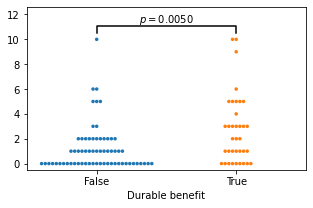

In [42]:
plt.figure(figsize=(5, 3))

n_mutation_genes = hrtw_tso500[genes].sum(axis=1)
condition = X_hrtw['Durable benefit'] == 'Yes'

x1 = hrtw_tso500[genes].sum(axis=1)[~condition]
x2 = hrtw_tso500[genes].sum(axis=1)[condition]
_, p_value = ks_2samp(x1, x2)

sns.swarmplot(x=condition, y=n_mutation_genes,  s=3.5)
plot_pvalue(x_values=[0, 1], y_values=n_mutation_genes, pvalue=p_value, ax=plt.gca(), symbol='p')

# Classifier based on the genes.
Test whether the genes are confounders of TMB. First analyse all significant genes.

In [43]:
import statsmodels.api as sm

In [44]:
not_na_hrtw = hrtw_tso500['durable_benefit'].notna()
y_hrtw = hrtw_tso500.loc[not_na_hrtw, 'durable_benefit']
features = sorted(genes)
X_hrtw = concat([hrtw_tso500.loc[not_na_hrtw, features], hrtw_tmb.loc[not_na_hrtw,'tmb']], axis='columns')

In [45]:
# Baseline model with only TMB
exog_tmb = sm.add_constant(X_hrtw[['tmb']])
baseline = sm.Logit(y_hrtw.values, exog_tmb).fit()
baseline.summary()

Optimization terminated successfully.
         Current function value: 0.609390
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   93
Model:                          Logit   Df Residuals:                       91
Method:                           MLE   Df Model:                            1
Date:                Mon, 19 Sep 2022   Pseudo R-squ.:                 0.08696
Time:                        13:54:49   Log-Likelihood:                -56.673
converged:                       True   LL-Null:                       -62.071
Covariance Type:            nonrobust   LLR p-value:                  0.001017
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4005      0.399     -3.511      0.000      -2.182      -0.619
tmb            0.1170      0.043      2.749      0.006       0.034       0.200
==============================================================================
"""

In [46]:
# Baseline model with only TMB
exog_all = sm.add_constant(X_hrtw[['tmb'] + features])
model_all = sm.Logit(y_hrtw.values, exog_all).fit()
model_all.summary()

Optimization terminated successfully.
         Current function value: 0.509118
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   93
Model:                          Logit   Df Residuals:                       83
Method:                           MLE   Df Model:                            9
Date:                Mon, 19 Sep 2022   Pseudo R-squ.:                  0.2372
Time:                        13:54:49   Log-Likelihood:                -47.348
converged:                       True   LL-Null:                       -62.071
Covariance Type:            nonrobust   LLR p-value:                 0.0005447
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.8769      0.511     -3.675      0.000      -2.878      -0.876
tmb            0.1666      0.077      2.152      0.031       0.015       0.318
ATM           -1.8648      1.044     -1.787      0.074      -3.910       0.181
EPHA5          0.8116      0.627      1.295      0.195      -0.417       2.040
LRP1B         -0.4798      0.326     -1.472      0.141      -1.118       0.159
MTOR           1.1781      1.031      1.143      0.253      -0.843       3.199
NRG1          -3.7956      1.408     -2.696      0.007      -6.555      -1.036
PTPRD          0.8095      0.735      1.101      0.271      -0.632       2.251
PTPRT          0.8659      0.642      1.348      0.178      -0.393       2.125
RUNX1T1        0.9443      0.867      1.090      0.276      -0.754       2.643
==============================================================================
"""

In other words, the TMB has hardly been affected bu the other features. So these genes do not explain away the TMB.

## Confounding DNA repair
Is TMB confounded by only the DNA repair? We use the definition of 10 % change in the regression coefficient. First, test EPHA5:

In [47]:
exog_repair = sm.add_constant(X_hrtw[['tmb','EPHA5']])
model_repair = sm.Logit(y_hrtw.values, exog_repair).fit()
print(model_repair.summary())

Optimization terminated successfully.
         Current function value: 0.608039
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   93
Model:                          Logit   Df Residuals:                       90
Method:                           MLE   Df Model:                            2
Date:                Mon, 19 Sep 2022   Pseudo R-squ.:                 0.08899
Time:                        13:54:49   Log-Likelihood:                -56.548
converged:                       True   LL-Null:                       -62.071
Covariance Type:            nonrobust   LLR p-value:                  0.003992
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4135      0.400     -3.531      0.000      -2.198      -0.629
tmb            0.1112      0.

In [48]:
model_repair.summary().tables[1]#['tmb', 'coef']

<class 'statsmodels.iolib.table.SimpleTable'>

In [49]:
dtmb = (0.1112 - 0.1170)/0.1170 * 100
print('Percentage change regression coefficient TMB: {:.1f} %'.format(dtmb))

Percentage change regression coefficient TMB: -5.0 %


**Conclusion**: EPHA5 is not confounder.

Amount of change with ATM.

In [50]:
exog_repair = sm.add_constant(X_hrtw[['tmb', 'ATM']])
model_repair = sm.Logit(y_hrtw.values, exog_repair).fit()
print(model_repair.summary())

Optimization terminated successfully.
         Current function value: 0.589624
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   93
Model:                          Logit   Df Residuals:                       90
Method:                           MLE   Df Model:                            2
Date:                Mon, 19 Sep 2022   Pseudo R-squ.:                  0.1166
Time:                        13:54:50   Log-Likelihood:                -54.835
converged:                       True   LL-Null:                       -62.071
Covariance Type:            nonrobust   LLR p-value:                 0.0007201
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.5391      0.430     -3.583      0.000      -2.381      -0.697
tmb            0.1552      0.

In [51]:
dtmb = (0.1552 - 0.1170)/0.1170 * 100
print('Percentage change regression coefficient TMB: {:.1f} %'.format(dtmb))

Percentage change regression coefficient TMB: 32.6 %


**Conclusion**: ATM is a confounder.

In [52]:
# Baseline model with only TMB
exog_nrg1 = sm.add_constant(X_hrtw[['tmb'] + ['NRG1']])
model_nrg1 = sm.Logit(y_hrtw.values, exog_nrg1).fit()
model_nrg1.summary()

Optimization terminated successfully.
         Current function value: 0.574806
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   93
Model:                          Logit   Df Residuals:                       90
Method:                           MLE   Df Model:                            2
Date:                Mon, 19 Sep 2022   Pseudo R-squ.:                  0.1388
Time:                        13:54:50   Log-Likelihood:                -53.457
converged:                       True   LL-Null:                       -62.071
Covariance Type:            nonrobust   LLR p-value:                 0.0001815
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.8318      0.469     -3.910      0.000      -2.750      -0.913
tmb            0.1926      0.058      3.334      0.001       0.079       0.306
NRG1          -2.6128      1.127     -2.318      0.020      -4.822      -0.403
==============================================================================
"""